# How To Use Vertex Text-to-Image Generative AI To Build Dynamic Banners

This notebook outlines how to interact with Vertex AI's Text-to-Image GenAI models to create content for dynamic website banners. With Imagen on Vertex AI, developers can utilize next-generation AI products to transform their imagination into high quality visual assets, in seconds. With just some simple lines of Python, we can merge these assets with existing content to provide a new level of visual website content.

## Prepare the python development environment

First, let's identify any project specific variables to customize this notebook to your GCP environment. Change YOUR_PROJECT_ID with your own GCP project ID.

In [51]:
PROJECT_ID = "rkiles-demo-host-vpc"

Install any needed python modules from our requirements.txt file. Most Vertex Workbench environments include all the packages we'll be using, but if you are using an external Jupyter Notebook or require any additional packages for your own needs, you can simply add them to the included requirements.txt file an run the folloiwng commands.

In [52]:
pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


Now we will import all required modules. For our purpose, we will be utilizing the following:

- google.auth - Provides authentication access to the Google API's, such as imagegeneration:predict
- PIL - An easy to use Python image library to help build the background for our banner and perform image layering
- io - Core python libray used to work with I/O. We will use this to help convert strings to byte objects for PIL
- base64 - Imagen API requests return generated or edited images as base64-encoded strings. This module will help us decode this data to an image file
- requests - This module will allow us to interact directly with Imagen over the REST API. 
- json - Python module used to interact with JSON data. Imagen returns results in json format.

In [53]:
import google.auth.transport.requests
import google.auth
from PIL import Image
from io import BytesIO
import base64
import requests
import json

## Authenticate to the Vertex AI API

Our Vertex Workbench instance is configured to use a specified service account that has IAM access to the text-to-vision API. The following two secitons will allow us to generate the access token we will pass as an authorization bearer token later in the header.

In [54]:
credentials, project_id = google.auth.default()
auth_req = google.auth.transport.requests.Request()
credentials.refresh(auth_req)

In [55]:
access_token = credentials.token

## Prepare the HTTP POST request to the REST API

Define the header fields, including the access token we created in the last step

In [56]:
headers = {
        'Authorization': 'Bearer ' + access_token,
        'Content-Type': 'application/json; charset=utf-8'
    }

You can uncomment the following line for troubleshooting if you want to see how the header will be passed to the API.

In [57]:
#print(headers)

Next we will specifiy the URL for the Imagen REST API. You should have already specified the correct project ID in the very first step of this notebook.

In [58]:
url = f'https://us-central1-aiplatform.googleapis.com/v1/projects/{PROJECT_ID}/locations/us-central1/publishers/google/models/imagegeneration:predict'

To use Imagen on Vertex AI you must provide a text description of what you want to generate or edit. These descriptions are called prompts, and these prompts are the primary way you communicate with Generative AI. Here, we are specifiying what we want the model to create using a prompt. Play around with this content and see what kind of images you can create. More information can be found here https://cloud.google.com/vertex-ai/docs/generative-ai/image/img-gen-prompt-guide

In [59]:
imagen_prompt = "yellow handbag on a mountain top"

The REST API expects a json payload containing the data that will be used to generate the image. We are only passing a few of the available request options below, but you can find more information about the REST API and additional featuers here https://cloud.google.com/vertex-ai/docs/generative-ai/image/generate-images#-drest

In this example, we are providing the prompt information from the last step and specifiying a single image sample to be returned. 

In [60]:
request_body = '{"instances": [{"prompt": "' + imagen_prompt + '"}],"parameters": {"sampleCount": 1}}'

Lastly, we will post the request to the Imagen REST API and wait for the requested image to be generated and returned

In [61]:
r = requests.post(url, data=request_body, headers=headers)

You can optionally uncomment the following to view the returned status code for verification or troubleshooting

In [62]:
#print(r.status_code)

## Process the returned request and decode the image

The Imagen API returns images in a base64 encoded JSON string. We will start by defining our data and then decoding the image.

In [63]:
img_data = r.json()

You can optionally uncomment this line to see the full JSON payload returned by the API.

In [64]:
#print(img_data["predictions"][0]["bytesBase64Encoded"])

We will be using just the first returned image sample in this example. The API can return up to 8 sample images, so you could insert a simple for loop here to iterate through multiple images.

In [65]:
encoded_image = img_data["predictions"][0]["bytesBase64Encoded"]

This will decode the base64 string to a usable image

In [66]:
decoded_image = base64.b64decode(encoded_image)

Optionally uncomment this line to save the image to disk

In [67]:
#with open("b64DecodedImage1.png", "wb") as fh:
#    fh.write(decoded_image)

We will be keeping this image in memory since we will be making further modifications before saving the final image.

In [68]:
byte_stream = BytesIO(decoded_image)

Let's view the returned iamge from Imagen

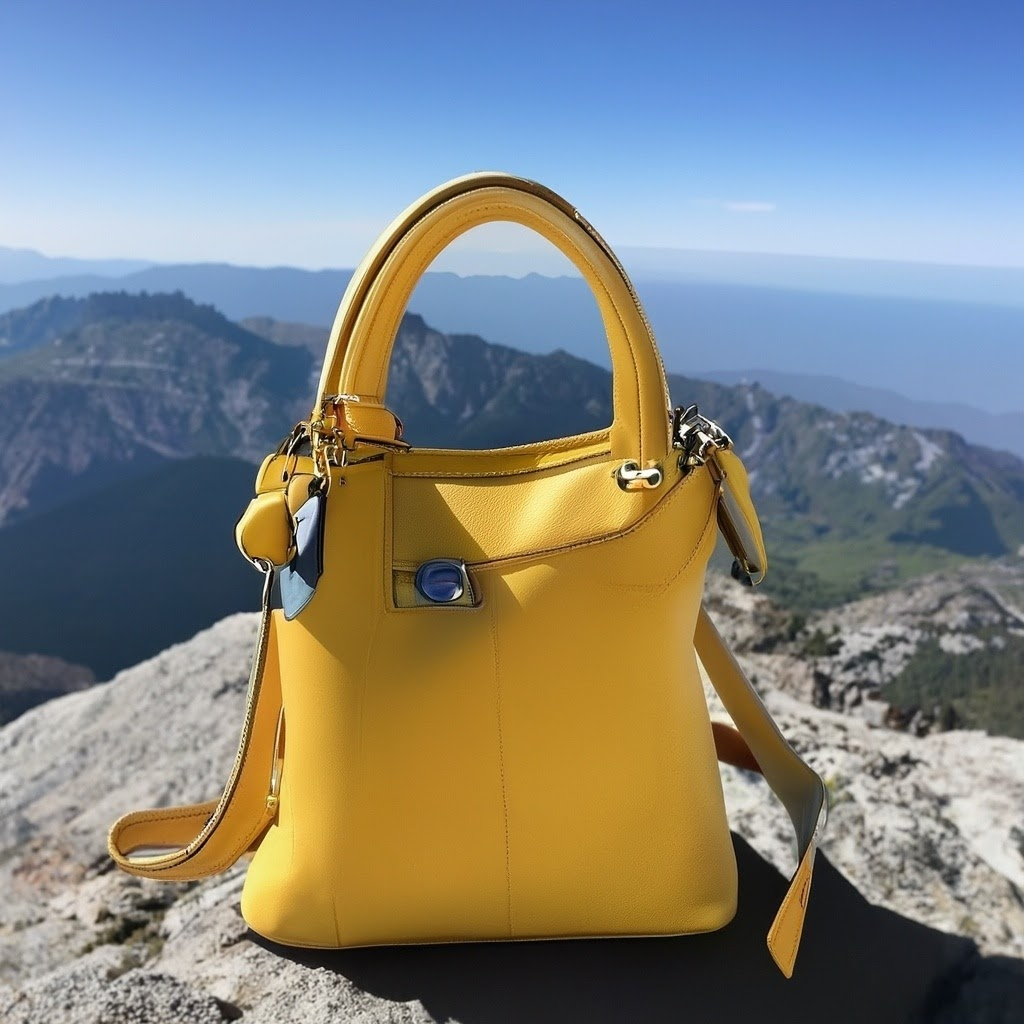

In [69]:
genImage = Image.open(byte_stream).convert("RGBA")
genImage.convert("RGB")

## Create our background for the banner

Our banner background will be a solid dark blue. Imagen generates images that are 1024x1024, so if we want our final banner to be 468x60, we will need to create our background at a size of 7987x1024 and then scale the final image down.

In [70]:
im_background = Image.new(mode = "RGBA", size = (7987, 1024), color = (10, 60, 140))

Let's take a look at our new background. PIL creates a temporary jpeg for display purposes, so let's specify this as an RGB image to remove the alpha channels and avoid any error messages. 

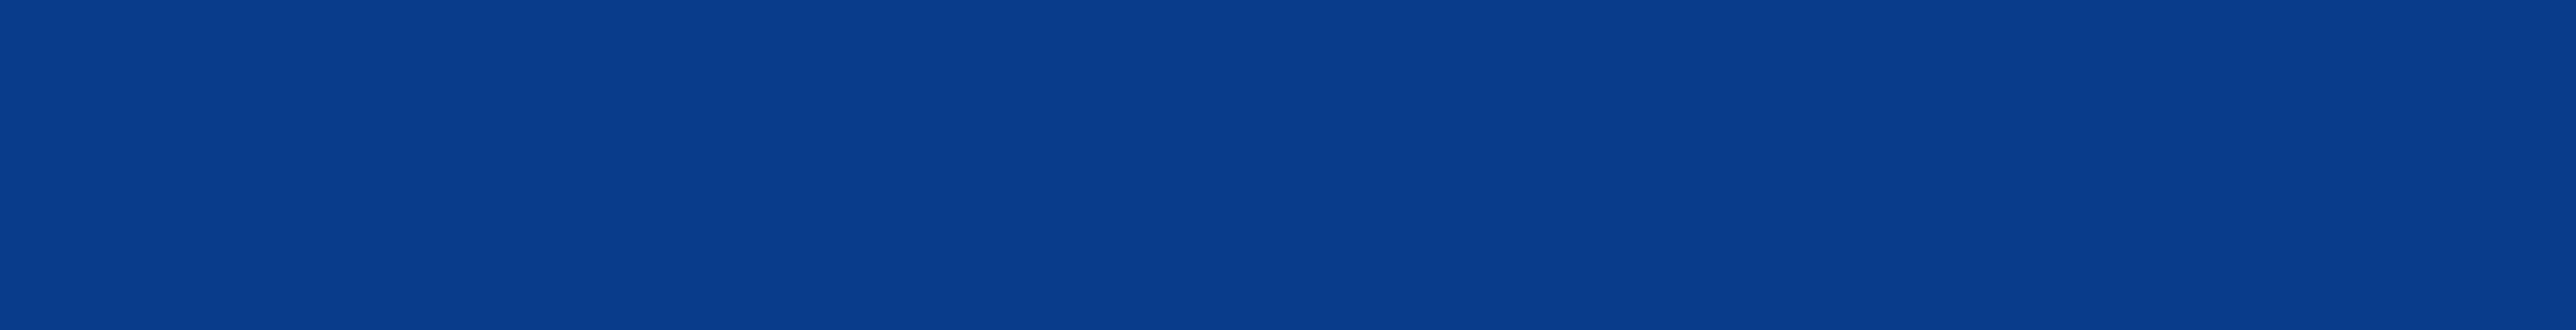

In [71]:
im_background.convert("RGB")

## Layer our banner images and create our final image

Now we will define all of the images we will use in our final banner. These will consisting of our background, Imagen generated image, some sample text, and a corporate logo.

In [72]:
image1 = im_background
image2 = Image.open(byte_stream).convert("RGBA")
image3 = Image.open("SSE-text.png").convert("RGBA")
image4 = Image.open("corp-logo.png").convert("RGBA")

This section covers how we will layer the images over the background.

In [73]:
image1.paste(image2, (100,0), mask = image2)
image1.paste(image3, (1300,20), mask = image3)
image1.paste(image4, (3500,200), mask = image4)

Lastly we will resize the final image to our target banner size and display the results

In [74]:
image1 = image1.resize((468, 60))

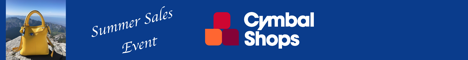

In [75]:
image1.convert('RGB')

You can uncomment this line to save the final image to disk

In [ ]:
#image1.save("result.png")

That's it! Congratulations on creating your first dynamic banner with Imagen!